# Import modules

updated with CuDNNLSTM

In [1]:
import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

import math
from sklearn.preprocessing import RobustScaler
from collections import deque

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import the CSV file with technical data and sentiment analysis

In [2]:
data = pd.read_hdf('data2.h5', 'new_data')
#data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
data['Y'] = data.lrets.shift(-1)
data.dropna(axis=0, inplace=True)
data.head()

,Adj Close,Volume,lrets,MACD,stochastics,ATR,neg,neu,pos,Y
1990-01-30,322.980011,186030000.0,-0.006850,-1.512383,0.000000,5.900024,0.043,0.910,0.047,-0.000882
1990-02-01,328.790009,154580000.0,-0.000882,-1.185424,18.857509,6.879974,0.073,0.870,0.057,0.002806
1990-02-05,331.850006,130950000.0,0.002806,-0.738707,28.789340,3.369995,0.106,0.815,0.080,-0.002370
1990-02-08,332.959991,176240000.0,-0.002370,-0.328807,39.060605,4.239990,0.030,0.937,0.034,0.001980
1990-02-09,333.619995,146910000.0,0.001980,0.019442,41.643793,2.190002,0.055,0.901,0.045,0.002844


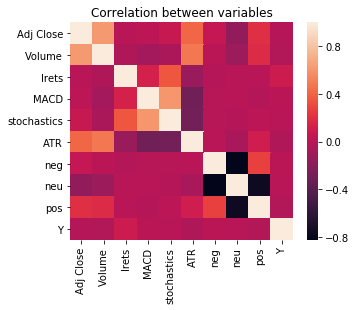

In [3]:
corr = data.corr()
f, ax = plt.subplots(figsize=(5, 4))
plt.title("Correlation between variables")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Train Test split for recurrent neural net

http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

https://pythonprogramming.net/crypto-rnn-model-deep-learning-python-tensorflow-keras/?completed=/balancing-rnn-data-deep-learning-python-tensorflow-keras/

In [4]:
d = deque('ghi')                 # make a new deque with three items
for elem in d:                   # iterate over the deque's elements
    print (elem.upper())

G
H
I


In [5]:
def preprocess_df(data, shuffle=True):
    mapped_data = data.copy()
    SEQ_LEN = 60

    scaler = RobustScaler()
    data = scaler.fit_transform(data)

    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in data:  # iterate over the values
        prev_days.append([n for n in i[:-1]])  # store all but the target

        # if prev_days have 60 days of data
        if len(prev_days) == SEQ_LEN:
            # sequential_data = [prev_days_data, target variable]
            sequential_data.append([np.array(prev_days), i[-1]])  
    if shuffle == True:
        random.shuffle(sequential_data)  # shuffle for good measure.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
    
    if shuffle == True:
        return np.array(X), y 
    else:
        return np.array(X), y, mapped_data, scaler

In [6]:
times = sorted(data.index.values)
last_5pct = sorted(data.index.values)[-int(0.05*len(times))]

validation_main_df = data[(data.index >= last_5pct)]
main_df = data[(data.index < last_5pct)]

prescaler = RobustScaler()
prescaler = prescaler.fit(validation_main_df)

X_train, y_train = preprocess_df(main_df)
X_val, y_val, mapped_data, prescaler = preprocess_df(validation_main_df, shuffle=False)

# Stochastic Gradient descent with restart

Replacing Adam optimizer with SGDR for better performance

https://www.jeremyjordan.me/nn-learning-rate/

In [7]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

# Learning rate finder

In [8]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

# Build up GRU model

- Adam Optimizer = RMSProp + Momentum

- RMSE should be more useful when large errors are particularly undesirable.

- Batchnorm and dropout for regularization

- https://www.quora.com/What-is-the-difference-between-dropout-and-batch-normalization

In [11]:
def build_model():
    model = Sequential()
    model.add(CuDNNLSTM(256, input_shape=(X_train.shape[1:]), return_sequences=True))
    model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

    model.add(CuDNNLSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(CuDNNLSTM(64))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='tanh'))
    
    opt = tf.keras.optimizers.RMSprop(lr=7e-3)
    model.compile(loss='mse',optimizer=opt, metrics=['mse'])
    return model

In [12]:
model = build_model()

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

Epoch 1/1
4562/4562 [==============================] - 11s 2ms/step - loss: 2.1090 - mean_squared_error: 2.1090


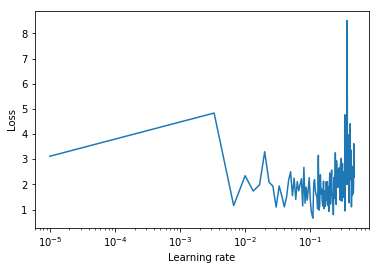

In [87]:
# find learning rate first
epoch_size = 20
batch_size = 256

lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-2, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=3)
model.fit(X_train, y_train, callbacks=[lr_finder])

lr_finder.plot_loss()

In [88]:
model = build_model()
schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(epoch_size/batch_size),
                         lr_decay=0.9,
                         cycle_length= 3,
                         mult_factor=1.5)

model.fit(
    X_train,
    y_train,
    epochs=20, 
    callbacks=[schedule],
    validation_split=0.1,
    verbose=1)

Train on 4105 samples, validate on 457 samples
Epoch 1/20
4105/4105 [==============================] - 11s 3ms/step - loss: 1.7349 - mean_squared_error: 1.7349 - val_loss: 1.5083 - val_mean_squared_error: 1.5083
Epoch 2/20
4105/4105 [==============================] - 9s 2ms/step - loss: 1.5201 - mean_squared_error: 1.5201 - val_loss: 1.4421 - val_mean_squared_error: 1.4421
Epoch 3/20
4105/4105 [==============================] - 9s 2ms/step - loss: 1.4363 - mean_squared_error: 1.4363 - val_loss: 1.4503 - val_mean_squared_error: 1.4503
Epoch 4/20
4105/4105 [==============================] - 9s 2ms/step - loss: 1.4238 - mean_squared_error: 1.4238 - val_loss: 1.4527 - val_mean_squared_error: 1.4527
Epoch 5/20
4105/4105 [==============================] - 9s 2ms/step - loss: 1.4171 - mean_squared_error: 1.4171 - val_loss: 1.4516 - val_mean_squared_error: 1.4516
Epoch 6/20
4105/4105 [==============================] - 9s 2ms/step - loss: 1.4099 - mean_squared_error: 1.4099 - val_loss: 1.4811 -

In [89]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train RMSE: %2f' % math.sqrt(trainScore[0]))

testScore = model.evaluate(X_val, y_val, verbose=0)
print('Test RMSE: %2f'% math.sqrt(testScore[0]))

Train RMSE: 1.180668
Test RMSE: 1.681138


In [181]:
p = model.predict(X_val)

If the chosen model fits worse than a horizontal line, then R2 is negative.

# Plotting Predicted value vs True value

In [185]:
padding = np.zeros((184, 9))
pred_result = pd.DataFrame(data=padding)
pred_result['9'] = p
pred = prescaler.inverse_transform(pred_result)

val_result = pd.DataFrame(data=padding)
val_result['9'] = y_val
val = prescaler.inverse_transform(val_result)

In [188]:
pred = pred[:, -1]
val = val[:, -1]

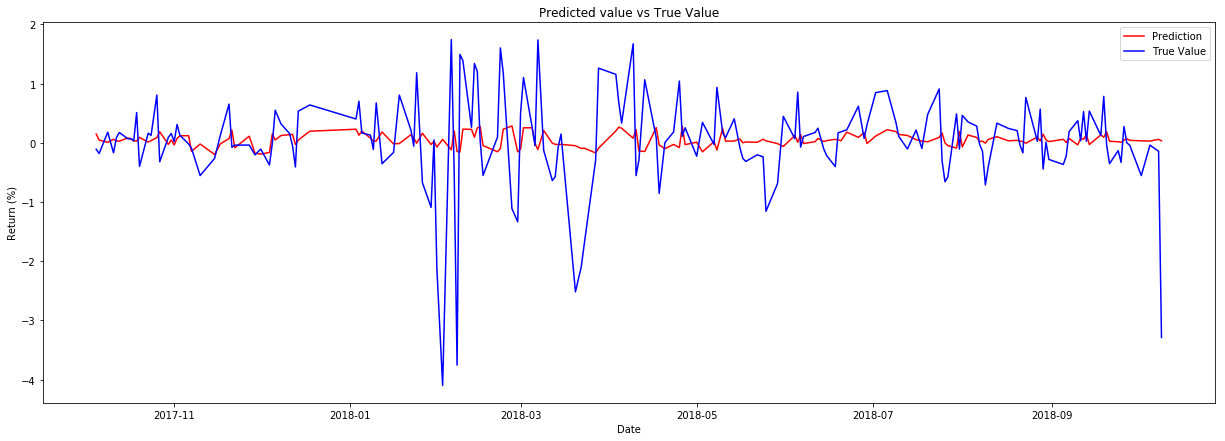

In [194]:
plt.figure(figsize=(21,7))
plt.plot(data.index[-len(pred):], np.expm1(pred)*100, color='red', label='Prediction')
plt.plot(data.index[-len(val):], np.expm1(val)*100, color='blue', label='True Value')
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.title('Predicted value vs True Value')
plt.legend(loc='best')
plt.show()

# The residual plot is not normal

((array([-2.67289247, -2.36046913, -2.18213076, -2.05428693, -1.95319937,
         -1.86884759, -1.7960154 , -1.73162634, -1.67370719, -1.62091343,
         -1.57228594, -1.52711548, -1.48486215, -1.44510502, -1.40750925,
         -1.37180394, -1.33776662, -1.30521228, -1.27398532, -1.24395353,
         -1.21500362, -1.18703768, -1.15997053, -1.13372755, -1.10824298,
         -1.08345855, -1.05932238, -1.03578805, -1.01281386, -0.99036218,
         -0.96839893, -0.94689317, -0.92581667, -0.90514361, -0.88485034,
         -0.86491508, -0.84531776, -0.82603984, -0.80706413, -0.78837467,
         -0.76995661, -0.75179612, -0.73388025, -0.71619691, -0.69873475,
         -0.68148309, -0.66443192, -0.64757178, -0.63089375, -0.61438939,
         -0.59805072, -0.58187017, -0.56584054, -0.54995501, -0.53420707,
         -0.51859052, -0.50309943, -0.48772815, -0.47247125, -0.45732355,
         -0.44228007, -0.42733602, -0.41248681, -0.39772801, -0.38305534,
         -0.36846467, -0.35395204, -0.

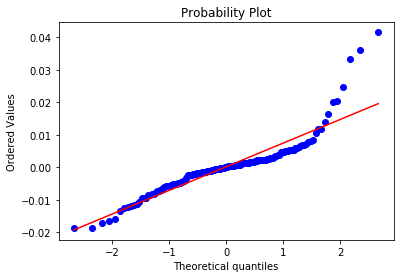

In [192]:
import scipy.stats as stats
residual = np.expm1(pred) - np.expm1(val)
stats.probplot(residual, dist="norm", plot=plt)

In [195]:
# Updates to be continued